In [ ]:
import numpy as np
import csv
import datetime
import time

In [ ]:
def addElement(array, index, ele):
    if array and index < len(array):
        array[index] += ele
        return array
    newArray = [0] * (index + 1)
    if array:
        newArray[:len(array)] = array
    newArray[index] = ele
    return newArray

In [ ]:
trafficRecordsById = {}
startTime = 1433142000

with open("new.csv") as f:
    trafficRecords = csv.reader(f, delimiter=',')
    count = 0
    for trafficRecord in trafficRecords:
        if count % 100000 == 0:
            print (count / 24015249 * 100, "%")
#         if count == 30000:
#             break
        recordTime = trafficRecord[1]
        checkPointId = trafficRecord[2]
        lane = int(trafficRecord[3])
        traffic = int(trafficRecord[4])

        relativeTime = time.mktime(datetime.datetime.strptime(recordTime, "%Y-%m-%d %H:%M:%S").timetuple()) - startTime
#         print (relativeTime)
        intervalId = relativeTime // 300
#         print (intervalId)
        
        trafficRecordsForId = trafficRecordsById.get(checkPointId)
        if not trafficRecordsForId:
            trafficByLane = addElement(None, lane, traffic)
            trafficRecordsById[checkPointId] = [(intervalId, trafficByLane)]
        else:
            prevIntervalId = trafficRecordsForId[-1][0]
            prevTrafficByLane = trafficRecordsForId[-1][1]
            if (intervalId == prevIntervalId):
                trafficRecordsForId[-1] = (intervalId, addElement(prevTrafficByLane, lane, traffic))
            else:
                trafficRecordsForId.append((intervalId, addElement(None, lane, traffic)))
        count += 1
                

import pickle

pickle.dump(trafficRecordsById, open("trafficRecordsById.p", "wb"))
    

In [1]:
import pickle
trafficRecordsByIdLoaded = pickle.load(open("trafficRecordsById.p", "rb"))

In [2]:
def checkMissingSpots(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    prevIndex = -1
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        if intervalId != prevIndex + 1:
            print (prevIndex, intervalId)
        prevIndex = intervalId

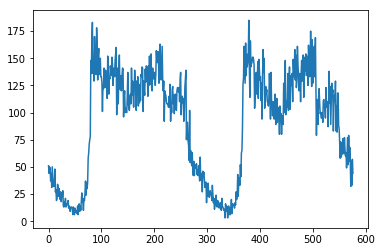

[(0.0, [24, 9, 5, 13]),
 (1.0, [17, 8, 4, 15]),
 (2.0, [18, 11, 5, 16]),
 (3.0, [15, 11, 3, 19]),
 (4.0, [17, 8, 1, 11]),
 (5.0, [18, 10, 3, 13]),
 (6.0, [12, 8, 1, 10]),
 (7.0, [19, 11, 4, 16]),
 (8.0, [16, 9, 3, 13]),
 (9.0, [15, 8, 1, 8]),
 (10.0, [14, 4, 2, 12]),
 (11.0, [9, 6, 4, 15]),
 (12.0, [23, 8, 2, 15]),
 (13.0, [14, 5, 2, 6]),
 (14.0, [13, 1, 4, 11]),
 (15.0, [11, 2, 2, 4]),
 (16.0, [8, 3, 2, 8]),
 (17.0, [14, 3, 3, 14]),
 (18.0, [15, 11, 1, 5]),
 (19.0, [12, 3, 2, 6]),
 (20.0, [14, 6, 2, 8]),
 (21.0, [7, 4, 0, 11]),
 (22.0, [11, 3, 1, 5]),
 (23.0, [10, 7, 0, 10]),
 (24.0, [7, 6, 0, 5]),
 (25.0, [12, 3, 0, 11]),
 (26.0, [8, 3, 1, 10]),
 (27.0, [12, 7, 1, 8]),
 (28.0, [6, 4, 1, 3]),
 (29.0, [5, 2, 2, 4]),
 (30.0, [5, 2, 1, 10]),
 (31.0, [8, 4, 0, 2]),
 (32.0, [9, 3, 1, 8]),
 (33.0, [7, 3, 0, 3]),
 (34.0, [5, 4, 0, 7]),
 (35.0, [10, 2, 0, 3]),
 (36.0, [6, 1, 1, 8]),
 (37.0, [6, 4, 0, 9]),
 (38.0, [5, 1, 1, 5]),
 (39.0, [6, 2, 0, 6]),
 (40.0, [3, 3, 1, 5]),
 (41.0, [4, 2, 1, 2

In [3]:
import matplotlib.pyplot as plt
import bisect
def plotTrafficDistribution(checkPointId, timeRange=(None, None), plot=True):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    if trafficRecordsForId is None:
        return
    keys = [ele[0] for ele in trafficRecordsForId]
    
    startIntervalId = timeRange[0]
    endIntervalId = timeRange[1]

    startIndex = 0
    endIndex = len(trafficRecordsForId)
    
    if startIntervalId is not None:
        startIndex = bisect.bisect_left(keys, startIntervalId)
    
    if endIntervalId is not None:
        endIndex = bisect.bisect_right(keys, endIntervalId)
        
    if plot:
        x, y = zip(*((ele[0], sum(ele[1])) for ele in trafficRecordsForId[startIndex: endIndex]))

        plt.plot(x, y)
        plt.show()
        
    return trafficRecordsForId[startIndex: endIndex]
    
plotTrafficDistribution("704", (0, 576))    
    

In [ ]:
checkMissingSpots("704")

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

ticksAheadToPredict = 6

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def intervalToRecords(trafficRecordsForId):
    intervalToRecordsMap = {}
    for trafficRecord in trafficRecordsForId:
        intervalToRecordsMap[trafficRecord[0]] = trafficRecord[1]
    return intervalToRecordsMap

def createDatasetSinglePoint(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    intervalToRecordsMap = intervalToRecords(trafficRecordsForId)
    X = []
    y = []

    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        timeInterval = intervalId % 288
        traffic1 = sum(intervalToRecordsMap.get(intervalId - 1)) if intervalToRecordsMap.get(intervalId - 1) is not None else None
        traffic2 = sum(intervalToRecordsMap.get(intervalId - 2)) if intervalToRecordsMap.get(intervalId - 2) is not None else None
        traffic3 = sum(intervalToRecordsMap.get(intervalId - 3)) if intervalToRecordsMap.get(intervalId - 3) is not None else None
        traffic4 = sum(intervalToRecordsMap.get(intervalId - 4)) if intervalToRecordsMap.get(intervalId - 4) is not None else None
        traffic288 = sum(intervalToRecordsMap.get(intervalId - 288)) if intervalToRecordsMap.get(intervalId - 288) is not None else None
#         print (traffic1, traffic2, traffic3)
        if None in (traffic1, traffic2, traffic3, traffic4, traffic288):
            continue
        y.append(sum(trafficRecord[1]))
        X.append([
            timeInterval,
            traffic1,
            traffic2,
            traffic3,
            traffic4,
            traffic288])
    return X, y

def createDatasetWithSurroundingPoints(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    intervalToRecordsMap = intervalToRecords(trafficRecordsForId)
    
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    
    X = []
    y = []

    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        timeInterval = intervalId % 288
        traffic1 = sum(intervalToRecordsMap.get(intervalId - 1)) if intervalToRecordsMap.get(intervalId - 1) is not None else None
        traffic2 = sum(intervalToRecordsMap.get(intervalId - 2)) if intervalToRecordsMap.get(intervalId - 2) is not None else None
        traffic3 = sum(intervalToRecordsMap.get(intervalId - 3)) if intervalToRecordsMap.get(intervalId - 3) is not None else None
        traffic4 = sum(intervalToRecordsMap.get(intervalId - 4)) if intervalToRecordsMap.get(intervalId - 4) is not None else None
        traffic288 = sum(intervalToRecordsMap.get(intervalId - 288)) if intervalToRecordsMap.get(intervalId - 288) is not None else None
#         print (traffic1, traffic2, traffic3)
        if None in (traffic1, traffic2, traffic3, traffic4, traffic288):
            continue
        y.append(sum(trafficRecord[1]))
        X.append([
            timeInterval,
            traffic1,
            traffic2,
            traffic3,
            traffic4,
            traffic288])
    return X, y

def gbm(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    X, y = createDatasetSinglePoint(checkPointId)
    splitPoint = len(trafficRecordsForId) // 10 * 8
    X_train, X_test = X[:splitPoint], X[splitPoint:]
    y_train, y_test = y[:splitPoint], y[splitPoint:]
    est = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
        max_depth=6, random_state=0, loss='huber').fit(X_train, y_train)
    print (mape(y_test, est.predict(X_test)))
    print (mean_squared_error(y_test, est.predict(X_test)))
    
gbm("704")


12.450422303
201.702301194


In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


def lstm(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    numpy.random.seed(7)

    X, y = createDataset(checkPointId)
    X = np.array(X)
    y = np.array(y)
    y = np.reshape(y, (-1, 1))
#     print (y)
    
    dataSet = np.concatenate((X, y), axis=1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataSet = scaler.fit_transform(dataSet)

    X, y = np.hsplit(dataSet, np.array([7]))
    
    splitPoint = len(trafficRecordsForId) // 10 * 9
    X_train, X_test = X[:splitPoint], X[splitPoint:]
    y_train, y_test = y[:splitPoint], y[splitPoint:]
    
    X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = numpy.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#     print (X_train.shape)
    model = Sequential()
    model.add(LSTM(128, input_shape=(40, 3)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)
    
    print (mape(y_test, model.predict(X_test)))

lstm("704") 